Epoch 1/50, Loss: 20.9127
Epoch 2/50, Loss: 6.5787
Epoch 3/50, Loss: 3.0577
Epoch 4/50, Loss: 2.5404
Epoch 5/50, Loss: 2.2612
Epoch 6/50, Loss: 2.0253
Epoch 7/50, Loss: 1.8391
Epoch 8/50, Loss: 1.6570
Epoch 9/50, Loss: 1.5025
Epoch 10/50, Loss: 1.3462
Epoch 11/50, Loss: 1.1947
Epoch 12/50, Loss: 1.0342
Epoch 13/50, Loss: 0.8750
Epoch 14/50, Loss: 0.7152
Epoch 15/50, Loss: 0.5689
Epoch 16/50, Loss: 0.4420
Epoch 17/50, Loss: 0.3378
Epoch 18/50, Loss: 0.2532
Epoch 19/50, Loss: 0.1899
Epoch 20/50, Loss: 0.1417
Epoch 21/50, Loss: 0.1057
Epoch 22/50, Loss: 0.0787
Epoch 23/50, Loss: 0.0566
Epoch 24/50, Loss: 0.0425
Epoch 25/50, Loss: 0.0318
Epoch 26/50, Loss: 0.0234
Epoch 27/50, Loss: 0.0175
Epoch 28/50, Loss: 0.0128
Epoch 29/50, Loss: 0.0092
Epoch 30/50, Loss: 0.0070
Epoch 31/50, Loss: 0.0050
Epoch 32/50, Loss: 0.0036
Epoch 33/50, Loss: 0.0025
Epoch 34/50, Loss: 0.0019
Epoch 35/50, Loss: 0.0014
Epoch 36/50, Loss: 0.0011
Epoch 37/50, Loss: 0.0008
Epoch 38/50, Loss: 0.0007
Epoch 39/50, Loss: 0

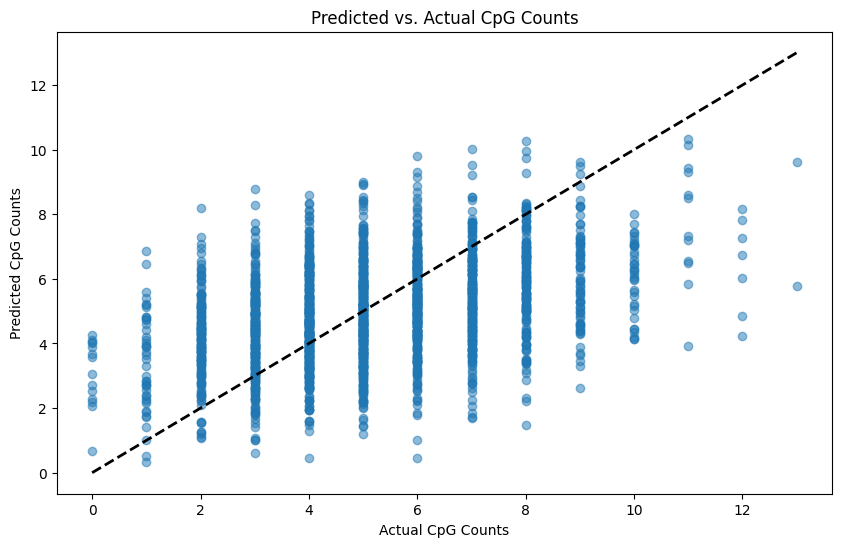

Maximum Error: 7.7732
Minimum Error: -6.1799


In [17]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from typing import Sequence
from functools import partial
import matplotlib.pyplot as plt

def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(13)

def rand_sequence(n_seqs: int, seq_len: int=128) -> Sequence[int]:
    for _ in range(n_seqs):
        yield [random.randint(0, 4) for _ in range(seq_len)]

def count_cpgs(seq: str) -> int:
    return sum(seq[i:i+2] == "CG" for i in range(len(seq) - 1))

alphabet = 'NACGT'
dna2int = {a: i for i, a in enumerate(alphabet)}
int2dna = {i: a for i, a in enumerate(alphabet)}
intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

def prepare_data(num_samples=100):
    X_dna_seqs = list(rand_sequence(num_samples))
    temp = [''.join(intseq_to_dnaseq(seq)) for seq in X_dna_seqs]
    y_dna_seqs = [count_cpgs(seq) for seq in temp]
    return X_dna_seqs, y_dna_seqs

def data_augmentation(X, y, augment_factor=2):
    augmented_X, augmented_y = [], []
    for seq, count in zip(X, y):
        augmented_X.append(seq)
        augmented_y.append(count)
        for _ in range(augment_factor - 1):
            new_seq = seq.copy()
            random.shuffle(new_seq)
            new_dna = ''.join(intseq_to_dnaseq(new_seq))
            new_count = count_cpgs(new_dna)
            augmented_X.append(new_seq)
            augmented_y.append(new_count)
    return augmented_X, augmented_y

def one_hot_encode(sequence, num_classes=5):
    sequence_tensor = torch.tensor(sequence, dtype=torch.long)
    one_hot = F.one_hot(sequence_tensor, num_classes=num_classes)
    return one_hot.float()

def normalize_data(data):
    return (data - data.mean()) / data.std()

train_x, train_y = prepare_data(4096)  # Increased dataset size
test_x, test_y = prepare_data(1024)

train_x, train_y = data_augmentation(train_x, train_y)
test_x, test_y = data_augmentation(test_x, test_y)

train_x_one_hot = [one_hot_encode(seq) for seq in train_x]
test_x_one_hot = [one_hot_encode(seq) for seq in test_x]

train_x_tensor = normalize_data(torch.stack(train_x_one_hot))
test_x_tensor = normalize_data(torch.stack(test_x_one_hot))

train_y_tensor = torch.tensor(train_y, dtype=torch.float32).view(-1, 1)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

batch_size = 128
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class SimpleCpGPredictor(nn.Module):
    def __init__(self, input_size=5*128, hidden_size=64, output_size=1):
        super(SimpleCpGPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCpGPredictor()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, loss_fn, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            inputs, labels = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}')

def evaluate_model(model, test_loader):
    model.eval()
    res_gs, res_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            outputs = model(inputs)
            res_gs.extend(labels.numpy().flatten())
            res_pred.extend(outputs.numpy().flatten())
    return np.array(res_gs), np.array(res_pred)

train_model(model, train_data_loader, loss_fn, optimizer)

res_gs, res_pred = evaluate_model(model, test_data_loader)

mse = np.mean((res_gs - res_pred) ** 2)
mae = np.mean(np.abs(res_gs - res_pred))
r2 = 1 - np.sum((res_gs - res_pred)**2) / np.sum((res_gs - np.mean(res_gs))**2)

print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

plt.figure(figsize=(10, 6))
plt.scatter(res_gs, res_pred, alpha=0.5)
plt.plot([res_gs.min(), res_gs.max()], [res_gs.min(), res_gs.max()], 'k--', lw=2)
plt.xlabel('Actual CpG Counts')
plt.ylabel('Predicted CpG Counts')
plt.title('Predicted vs. Actual CpG Counts')
plt.show()

errors = res_gs - res_pred
print(f'Maximum Error: {errors.max():.4f}')
print(f'Minimum Error: {errors.min():.4f}')

torch.save(model.state_dict(), 'cpg_detector_model.pth')